In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gamma
import seaborn as sns

In [30]:
rng = np.random.default_rng(70)

url = "https://www.sidc.be/silso/DATA/SN_m_tot_V2.0.txt"

cols = ["year", "month", "decimal_date", "sunspot",
        "std", "n_obs", "provisional"]

df = pd.read_csv(
    url,
    delim_whitespace=True,
    header=None,
    names=cols,
    comment='%'
)

df.head()

/tmp/ipython-input-2814602658.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df = pd.read_csv(


,year,month,decimal_date,sunspot,std,n_obs,provisional
0,1749,1,1749.042,96.7,-1.0,-1,NaN
1,1749,2,1749.123,104.3,-1.0,-1,NaN
2,1749,3,1749.204,116.7,-1.0,-1,NaN
3,1749,4,1749.288,92.8,-1.0,-1,NaN
4,1749,5,1749.371,141.7,-1.0,-1,NaN


#Plot the data over the years to see what the distribution might be like

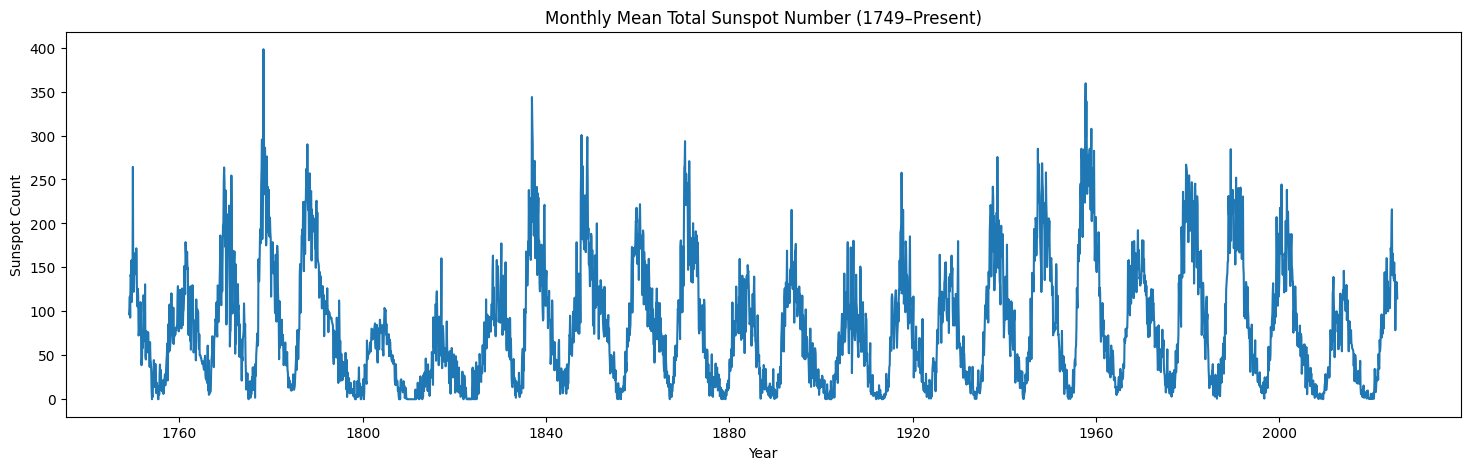

In [31]:
import matplotlib.pyplot as plt

df['date'] = pd.to_datetime(df[['year','month']].assign(day=1))
df = df.set_index('date')

plt.figure(figsize=(18,5))
plt.plot(df.index, df['sunspot'])
plt.xlabel("Year")
plt.ylabel("Sunspot Count")
plt.title("Monthly Mean Total Sunspot Number (1749–Present)")
plt.show()


#Model the phenomenon with a Gamma distribution, with a new cycle resetting every 12 years

In [32]:
df['cycle_id'] = (df.index.year - df.index.year.min()) // 12

cycle_params = []
for cid, g in df.groupby('cycle_id'):
    data = g['sunspot'].values
    data = data[data > 0]

    a, loc, b = gamma.fit(data, floc=0)
    cycle_params.append((cid, a, b))

params_df = pd.DataFrame(cycle_params, columns=['cycle_id','a','b'])
print(params_df)


    cycle_id          a           b
0          0   1.967849   37.430788
1          1   2.279457   44.079691
2          2   1.212215   79.531327
3          3   1.999882   57.620076
4          4   1.533798   27.990063
5          5   1.139687   33.191122
6          6   1.139439   55.385036
7          7   1.126351   83.657597
8          8   1.449976   70.539784
9          9   1.824838   50.792143
10        10   0.880750   99.084864
11        11   1.156332   55.269935
12        12   1.112766   53.614137
13        13   0.968933   60.795817
14        14   1.426622   58.769855
15        15   1.154110   77.448429
16        16   1.512557   68.513040
17        17   0.884518  130.047333
18        18   1.852426   45.215101
19        19   1.270938   86.175398
20        20   1.403227   78.640680
21        21   0.883661   74.090228
22        22   0.826834   75.639913
23        23  34.983887    3.615665


#Histogram of sunspot counts

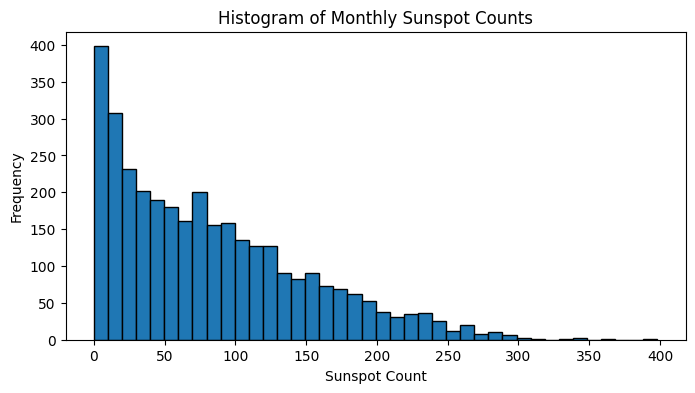

In [33]:
plt.figure(figsize=(8,4))
plt.hist(df['sunspot'], bins=40, edgecolor='black')
plt.xlabel("Sunspot Count")
plt.ylabel("Frequency")
plt.title("Histogram of Monthly Sunspot Counts")
plt.show()


#a = 4 and b = 10 so plot MCMC for groups: First 50 samples, All samples, Last 50 samples

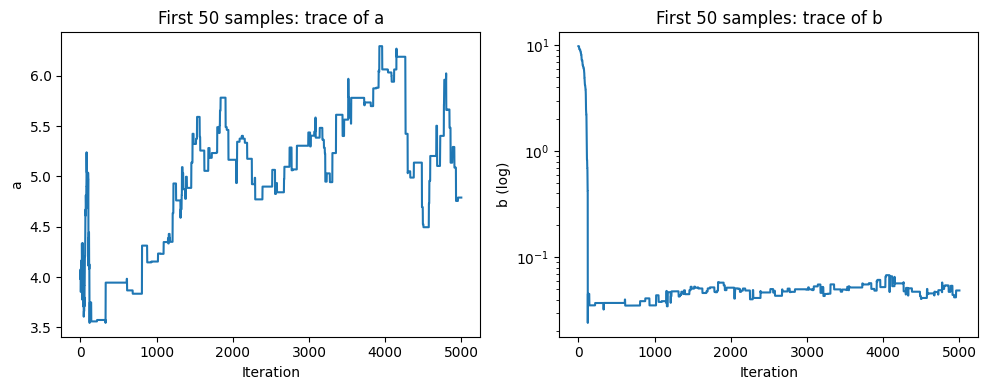

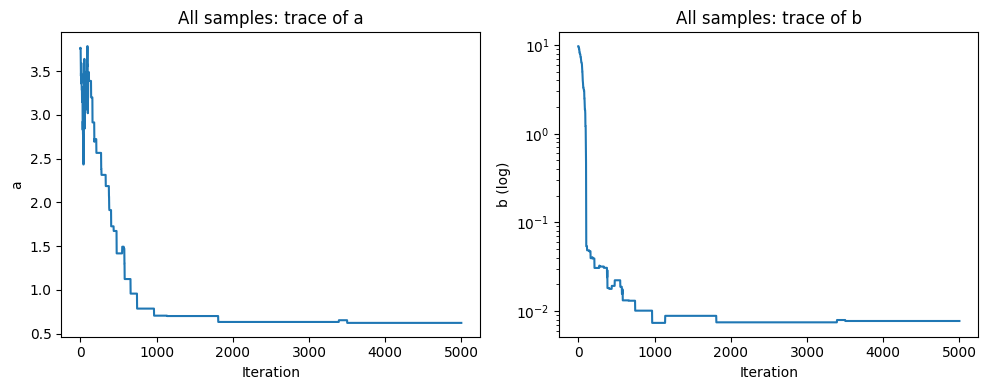

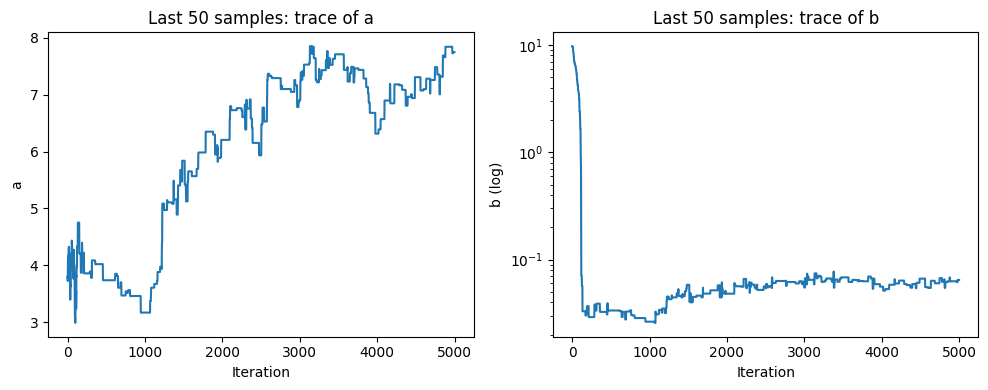

In [34]:
def log_posterior_gamma_ab(y, a, b):
    """
    Log posterior for Gamma(a, b) assuming:
    y_i ~ Gamma(a, b) with pdf(y|a,b) = b^a / Γ(a) * y^(a-1) * exp(-b y), y>0
    Prior: p(a,b) ∝ 1/(1+a^2) * 1/(1+b^2) (weakly informative proper-ish prior)
    """
    if a <= 0 or b <= 0:
        return -np.inf

    y = np.asarray(y)
    n = len(y)

    # log likelihood: sum over i
    # log p(y|a,b) = n[a ln b - ln Γ(a)] + (a-1) sum ln y_i - b sum y_i
    sum_log_y = np.sum(np.log(y + 1e-9))   # small epsilon to avoid log(0)
    sum_y = np.sum(y)

    from scipy.special import gammaln
    ll = n * (a * np.log(b) - gammaln(a)) + (a - 1) * sum_log_y - b * sum_y

    # simple log prior: log p(a) + log p(b) ~ -log(1+a^2) -log(1+b^2)
    lp = -np.log(1 + a**2) - np.log(1 + b**2)

    return ll + lp


def mcmc_gamma_ab(y, a0=4.0, b0=10.0, n_iter=5000, proposal_scale=(0.2, 0.2)):
    """
    Random-walk Metropolis-Hastings sampler for (a, b).
    proposal: a' = |a + N(0, s_a^2)|, b' = |b + N(0, s_b^2)|
    """
    y = np.asarray(y)
    a_chain = np.zeros(n_iter)
    b_chain = np.zeros(n_iter)

    a_curr = a0
    b_curr = b0
    log_post_curr = log_posterior_gamma_ab(y, a_curr, b_curr)

    s_a, s_b = proposal_scale

    for i in range(n_iter):
        # propose
        a_prop = abs(a_curr + rng.normal(0, s_a))
        b_prop = abs(b_curr + rng.normal(0, s_b))

        log_post_prop = log_posterior_gamma_ab(y, a_prop, b_prop)

        # acceptance prob
        log_alpha = log_post_prop - log_post_curr
        if np.log(rng.uniform()) < log_alpha:
            a_curr, b_curr, log_post_curr = a_prop, b_prop, log_post_prop

        a_chain[i] = a_curr
        b_chain[i] = b_curr

    return a_chain, b_chain

# --- 3 data groups ---
y_first50 = df["sunspot"].iloc[:50].values
y_all = df["sunspot"].values
y_last50 = df["sunspot"].iloc[-50:].values

# Run MCMC
a_first, b_first = mcmc_gamma_ab(y_first50, a0=4, b0=10)
a_all, b_all = mcmc_gamma_ab(y_all, a0=4, b0=10)
a_last, b_last = mcmc_gamma_ab(y_last50, a0=4, b0=10)

def plot_traces(a_chain, b_chain, title_prefix):
    iters = np.arange(len(a_chain))

    plt.figure(figsize=(10, 4))

    # a trace
    plt.subplot(1, 2, 1)
    plt.plot(iters, a_chain)
    plt.xlabel("Iteration")
    plt.ylabel("a")
    plt.title(f"{title_prefix}: trace of a")

    # b trace (log scale fix)
    plt.subplot(1, 2, 2)
    plt.plot(iters, b_chain)
    plt.yscale("log")
    plt.xlabel("Iteration")
    plt.ylabel("b (log)")
    plt.title(f"{title_prefix}: trace of b")

    plt.tight_layout()
    plt.show()
plot_traces(a_first, b_first, "First 50 samples")
plot_traces(a_all, b_all, "All samples")
plot_traces(a_last, b_last, "Last 50 samples")

#Visualise the traces of a and b and the histogram of the traces (drop some values known as burn-in)

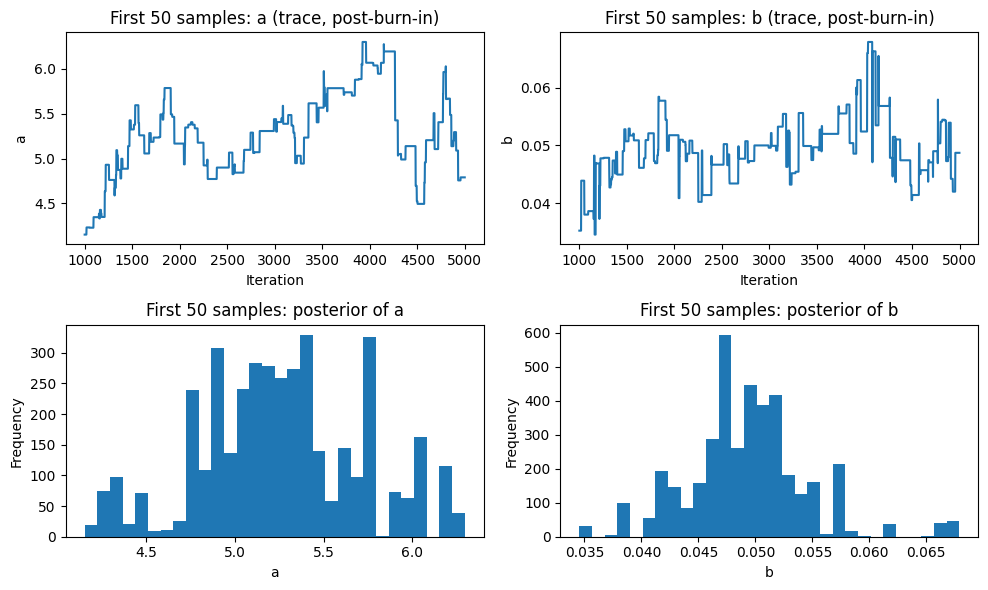

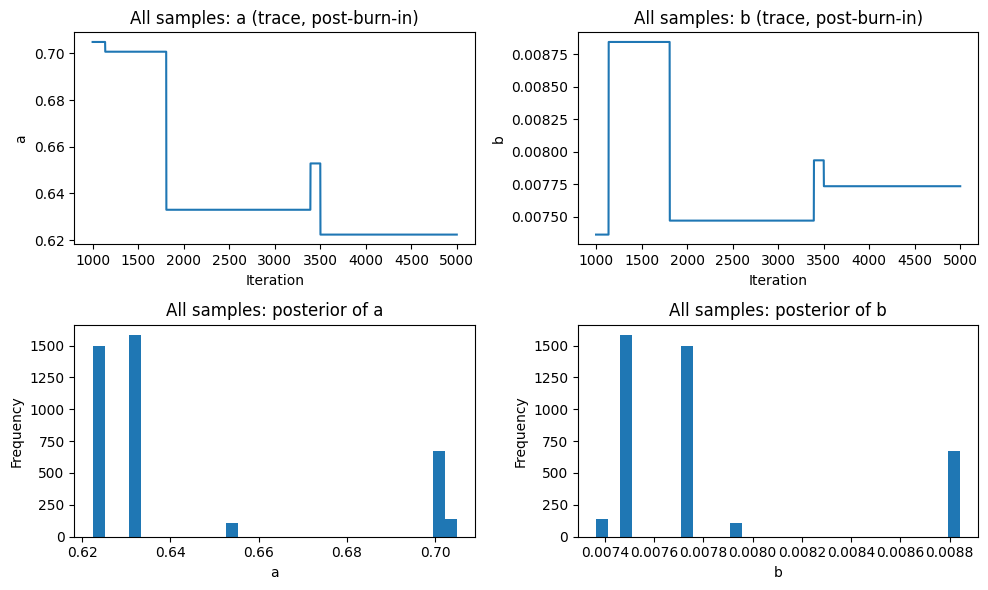

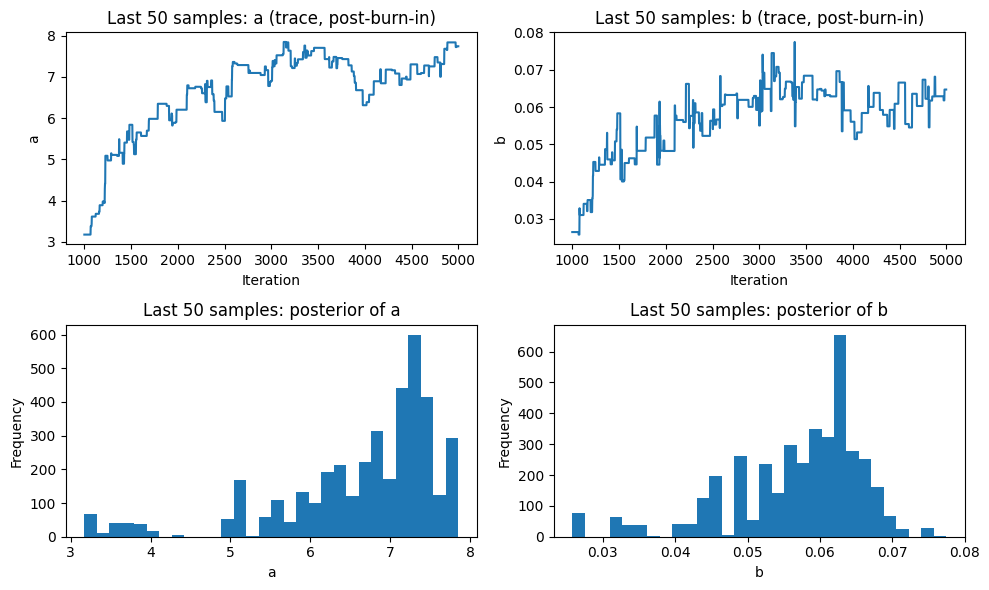

In [35]:
burn = 1000

def plot_posterior(a_chain, b_chain, title_prefix):
    a_post = a_chain[burn:]
    b_post = b_chain[burn:]

    # Trace after burn-in
    iters = np.arange(burn, len(a_chain))

    plt.figure(figsize=(10, 6))

    # trace of a
    plt.subplot(2, 2, 1)
    plt.plot(iters, a_post)
    plt.xlabel("Iteration")
    plt.ylabel("a")
    plt.title(f"{title_prefix}: a (trace, post-burn-in)")

    # trace of b
    plt.subplot(2, 2, 2)
    plt.plot(iters, b_post)
    plt.xlabel("Iteration")
    plt.ylabel("b")
    plt.title(f"{title_prefix}: b (trace, post-burn-in)")

    # hist of a
    plt.subplot(2, 2, 3)
    plt.hist(a_post, bins=30)
    plt.xlabel("a")
    plt.ylabel("Frequency")
    plt.title(f"{title_prefix}: posterior of a")

    # hist of b
    plt.subplot(2, 2, 4)
    plt.hist(b_post, bins=30)
    plt.xlabel("b")
    plt.ylabel("Frequency")
    plt.title(f"{title_prefix}: posterior of b")

    plt.tight_layout()
    plt.show()

plot_posterior(a_first, b_first, "First 50 samples")
plot_posterior(a_all, b_all, "All samples")
plot_posterior(a_last, b_last, "Last 50 samples")


#Prediction time of a and b

In [36]:
def posterior_summary(a_chain, b_chain, burn=1000):
    a_post = a_chain[burn:]
    b_post = b_chain[burn:]

    return {
        "a_mean": np.mean(a_post),
        "a_median": np.median(a_post),
        "a_95ci": np.percentile(a_post, [2.5, 97.5]),
        "b_mean": np.mean(b_post),
        "b_median": np.median(b_post),
        "b_95ci": np.percentile(b_post, [2.5, 97.5]),
    }

summary_first = posterior_summary(a_first, b_first)
summary_all = posterior_summary(a_all, b_all)
summary_last = posterior_summary(a_last, b_last)

print("First 50 samples:", summary_first)
print("All samples:", summary_all)
print("Last 50 samples:", summary_last)

First 50 samples: {'a_mean': np.float64(5.266190025797347), 'a_median': np.float64(5.233050986421049), 'a_95ci': array([4.3477973 , 6.19039293]), 'b_mean': np.float64(0.049370585697321376), 'b_median': np.float64(0.04959697705631885), 'b_95ci': array([0.03861957, 0.06131275])}
All samples: {'a_mean': np.float64(0.6433852278952362), 'a_median': np.float64(0.632993417830649), 'a_95ci': array([0.62235876, 0.70486846]), 'b_mean': np.float64(0.007809612708985628), 'b_median': np.float64(0.007735738800771749), 'b_95ci': array([0.00736434, 0.00884333])}
Last 50 samples: {'a_mean': np.float64(6.626680056856656), 'a_median': np.float64(6.938423120558728), 'a_95ci': array([3.61003383, 7.83905699]), 'b_mean': np.float64(0.05673569046783059), 'b_median': np.float64(0.059109261018110565), 'b_95ci': array([0.0310148 , 0.06921381])}
